In [1]:
## Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import logm, expm

## Plot settings
plt.rc('xtick', direction='in', labelsize=14)
plt.rc('ytick', direction='in', labelsize=14)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=14)

In [2]:
## Read coordinates and indices

grid_coordinates = []
with open('../../Grids/Pe_grid.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(',')
        point = (float(elements[0]),float(elements[1]))
        grid_coordinates.append(point)
        line = reader.readline()

jump_coordinates = []
with open('../../Grids/Pe_jump_coordinates.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            temp = ele.replace('(', '').replace(')', '')
            if temp != 'stop':
                x = temp.split(',')[0]
                y = temp.split(',')[1]
                point = (float(x),float(y))
                data_block.append(point)
            else:
                break
        line = reader.readline()
        jump_coordinates.append(data_block)

jump_indices = []
with open('../../Grids/Pe_jump_indices.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            if ele != 'stop':
                data_block.append(int(ele))
            else:
                break
        line = reader.readline()
        jump_indices.append(data_block)


# For drawing vertices use grid_coordinates
# For drawing lines use jump_coordinates
# For indices use jump_indices

In [3]:
## We now want to scale down the plot so it will fit inside a unit square in the 1st quadrant

# Compare x and y components seperatly to for the maximal distances along each axis
xs = [x for x,y in grid_coordinates]
ys = [y for x,y in grid_coordinates]

xs_length = abs(max(xs)) + abs(min(xs))
ys_length = abs(max(ys)) + abs(min(ys))

# We can now scale all xs and ys to fit inside a unit square
xs_scaled = [i/xs_length for i in xs]
ys_scaled = [i/ys_length for i in ys]
grid_scaled = [(x,y) for x, y in zip(xs_scaled, ys_scaled)]

# Same thing for all jump coodinates
jump_scaled = []
for i in jump_coordinates:
    xs_temp = [j[0]/xs_length for j in i]
    ys_temp = [j[1]/ys_length for j in i]
    jump_temp = [(x,y) for x, y in zip(xs_temp, ys_temp)]
    jump_scaled.append(jump_temp)


# The new vertices are stored in grid_scaled
# The new jumps are stored in jump_scaled


## Now we want to move the grid so it lies in the first quadrant 

# We check how much it should be moved along postive x axis and y axis
x_move = min(xs_scaled)
y_move = min(ys_scaled)

# Add the absolute to every coordinate
xs_final = [x + abs(x_move) for x in xs_scaled]
ys_final = [y + abs(y_move) for y in ys_scaled]
grid_final = [(x,y) for x, y in zip(xs_final, ys_final)]

jump_final = []
for i in jump_scaled:
    xs_temp = [j[0] + abs(x_move) for j in i]
    ys_temp = [j[1] + abs(y_move) for j in i]
    jump_temp = [(x,y) for x, y in zip(xs_temp, ys_temp)]
    jump_final.append(jump_temp)


# The new vertices are stored in grid_final
# The new jumps are stored in jump_final

In [4]:
## DEFINITION OF USEFUL FUNCTIONS

def Hamil_solve(z, w, B):
    # Define now a skeleton of the Hamiltonian 
    dim_H = len(z)
    H = np.zeros((dim_H, dim_H), dtype= np.complex128)
    k_H = [x for x in range(0, dim_H)]
    # Calculate Peierls phase factor according to the 1st artcle 
    
    # Start by finding the tile length
    tile_lens = [np.linalg.norm(np.array(z[0]) - np.array(x)) for x in w[0]]
    tile_lens_sum = np.sum(tile_lens)
    l  = tile_lens_sum/len(tile_lens)
    phi = B * l**2
    phi_0 = 2 * np.pi
    jump_products = []
    for i, j in zip(z, w):
        products = [i[0]*k[1] - k[0]*i[1] for k in j]
        jump_products.append(products)
    phase_factors = []
    for i, j in zip(z, jump_products):
        phases = [(phi/(2 * l**2)) * k for k in j]
        phase_factors.append(phases)

    # Scaling via J, maybe energy factor
    J = 1
    # Fill out the Hamiltonian according to the psi vector, i.e. the basis chosen through generation of the tiling
    for x, y, z in zip(k_H, jump_indices, phase_factors):
        for k, t in zip(y, z):
            H[x, k] = -J * np.exp(1j * t)

    # Now we find the eigenvalues and eigenvectors
    # Note that eigh returns normalized eigenvectors!
    # Note the eigenvectors are arranged in a matrix so eig_vecs[:,i] chooses the i'th column which is the i'th eigenvector
    eig_vals, U = np.linalg.eigh(H)
    eig_vecs = np.array([U[:,i] for i in range(len(U))])
    return eig_vals, eig_vecs

In [5]:
# We want to know when phi/phi0 = 1, this happens when phi = 2pi
# phi in this case is phi = B*l*2 so B must be equal to
max_B = (2*np.pi)/(0.055728090000841245**2 * np.sin(108*(np.pi/180)))

# Take field strength of B= 2pi so that phi/phi0= 0.5
evals, evecs = Hamil_solve(grid_final, jump_final, (0.1)*max_B)

In [6]:
# Now we must construct first construct diagonal matrices X and Y with Xij = xij * delta_ij and so on
xs = [x for (x,y) in grid_final]
X = np.diag(xs)
ys = [y for (x,y) in grid_final]
Y = np.diag(ys)
# With these we now define to unitary matrices from X and Y by exponentiating every entry as exp(i*2*pi xij)
# dtype should be all right after the exponentiation. This was checked by checking some entries and seeing them as complex
Ux = expm(1j*2*np.pi*X)
Uy = expm(1j*2*np.pi*Y)

# For use in the approximation function we define the adjoints of Ux and Uy
# d denotes dagger
Uxd = Ux.T.conj()
Uyd = Uy.T.conj()

# Now we can define the function that will be called to calculate the projection operator and calculate the corresponding Bott index
# It is done this way because the projector must be built recursively to minimise calculations and save time

def bott_index(ns, evec):
    # Set dimensions for later
    dim = range(len(grid_final))
    dims = len(grid_final)
    # Because the projection relies on inner products of eigenvectors we will be calculating these here 
    # Note np.vdot does complex conjugation of the first entry
    #dot_ps = [[np.vdot(i,m) for m in evec] for i in evec]
    dot_ps = [[m[i] for m in evec] for i in np.arange(0,dims)]

    # We create a matrix of zeroes with dimensions dim X dim, so that we need only fill it out with projections
    # We make sure to set dtype correctly to complex numbers
    P = np.zeros([dims,dims], dtype= np.complex128)

    # We also initialise the identity matrix of dimensions dim X dim for later use
    iden = np.identity(n= dims, dtype= np.complex128)

    # Now we iteratively put the dot products on the entries they belong to. To this end we loop of ns which indicate which eigenstate we are calculating the index of
    # Therefore we let the outer loop be the ns meaning we calculate the bott index inside each ns we loop through
    # Define now an empty list for indices
    indices = []
    for n in ns:
        # We now loop over the dimensions for both i and j but as a nested for loop
        # This is done so we can hit every entry first along the i'th row
        for i in dim:
            for j in dim:
                # Now we simply set the condition that we always add the product of two projections corresponding to the current n up to which we have be doing the sum
                P[i][j] += dot_ps[i][n] * (dot_ps[j][n]).conj()
                
        # With the matrix modified for the n'th entry we now find that we can calculate the Bott index 
        # To this end we firstly define the matrices Vx and Vy
        # We write out some matrix multiplication explicitly for readability
        # Note again we are explicit in the dtype to root out possible errors
        # First Ux
        Ux_P = np.matmul(Ux, P, dtype= np.complex128)
        P_Ux_P = np.matmul(P, Ux_P, dtype= np.complex128)
        Vx = iden - P + P_Ux_P
        # Repeat for Uy
        Uy_P = np.matmul(Uy, P, dtype= np.complex128)
        P_Uy_P = np.matmul(P, Uy_P, dtype= np.complex128)
        Vy = iden - P + P_Uy_P

        # Now we can calculate further producs of Vx and Vy and their adjoints
        # Again we do it rather explicitly and with dtype specified each time
        # Vxd denotes Vx dagger (adjoint) and so on
        Vxd = Vx.T.conj()
        Vyd = Vy.T.conj() 
        Vxd_Vyd = np.matmul(Vxd,Vyd, dtype= np.complex128)
        Vy_Vxd_Vyd = np.matmul(Vy, Vxd_Vyd, dtype= np.complex128)
        Vx_Vy_Vxd_Vyd = np.matmul(Vx, Vy_Vxd_Vyd, dtype= np.complex128)

        # Now we can calculate the n'th index by first calculating the matrix logarithm of the above matrix
        log_Vs = logm(Vx_Vy_Vxd_Vyd)
        tr = np.trace(log_Vs)
        Bn = (1/(2*np.pi)) * (tr.imag)
        
        # Save the indices
        indices.append(Bn)
    
    return indices


# To test an idea to find non-zero Bott indices we construct a function that will function much like the previous one, but calculatios might run slightly faster
def bott_approx(ns, evec):
    # Set dimensions for later
    dim = range(len(grid_final))
    dims = len(grid_final)
    # Because the projection relies on inner products of eigenvectors we will be calculating these here 
    # Note np.vdot does complex conjugation of the first entry
    
    ## TEMP COMMENT OUT
    #dot_ps = [[np.vdot(i,m) for m in evec] for i in evec]
    dot_ps = [[m[i] for m in evec] for i in np.arange(0,dims)]

    # We create a matrix of zeroes with dimensions dim X dim, so that we need only fill it out with projections
    # We make sure to set dtype correctly to complex numbers
    P = np.zeros([dims,dims], dtype= np.complex128)

    # Now we iteratively put the dot products on the entries they belong to. To this end we loop of ns which indicate which eigenstate we are calculating the index of
    # Therefore we let the outer loop be the ns meaning we calculate the bott index inside each ns we loop through
    # Define now an empty list for indices
    indices = []
    for n in ns:
        # We now loop over the dimensions for both i and j but as a nested for loop
        # This is done so we can hit every entry first along the i'th row
        for i in dim:
            for j in dim:
                # Now we simply set the condition that we always add the product of two projections corresponding to the current n up to which we have be doing the sum
                P[i][j] += dot_ps[i][n] * (dot_ps[j][n]).conj()

        # With the matrix modified for the n'th entry we now find that we can calculate the Bott index 
        # This uses eqn. 13 of the first article, we omit the correction term
        # Define matrix multiplication in explicit terms for readability
        Uyd_P = np.matmul(Uyd, P, dtype= np.complex128)
        P_Uyd_P = np.matmul(P, Uyd_P, dtype= np.complex128)
        Uxd_P_Uyd_P = np.matmul(Uxd, P_Uyd_P, dtype= np.complex128)
        P_Uxd_P_Uyd_P = np.matmul(P, Uxd_P_Uyd_P, dtype= np.complex128)
        Uy_P_Uxd_P_Uyd_P = np.matmul(Uy, P_Uxd_P_Uyd_P, dtype= np.complex128)
        P_Uy_P_Uxd_P_Uyd_P = np.matmul(P, Uy_P_Uxd_P_Uyd_P, dtype= np.complex128)
        Ux_P_Uy_P_Uxd_P_Uyd_P = np.matmul(Ux, P_Uy_P_Uxd_P_Uyd_P, dtype= np.complex128)
        P_Ux_P_Uy_P_Uxd_P_Uyd_P = np.matmul(P, Ux_P_Uy_P_Uxd_P_Uyd_P, dtype= np.complex128)
        # Now we can calculate the n'th index by first calculating the matrix logarithm of the above matrix
        tr = np.trace(P_Ux_P_Uy_P_Uxd_P_Uyd_P)
        Bn = (1/(2*np.pi)) * (tr.imag)
        
        # Save the indices
        indices.append(Bn)
    
    return indices

In [7]:
Botts = bott_index(range(len(grid_final)), evecs)

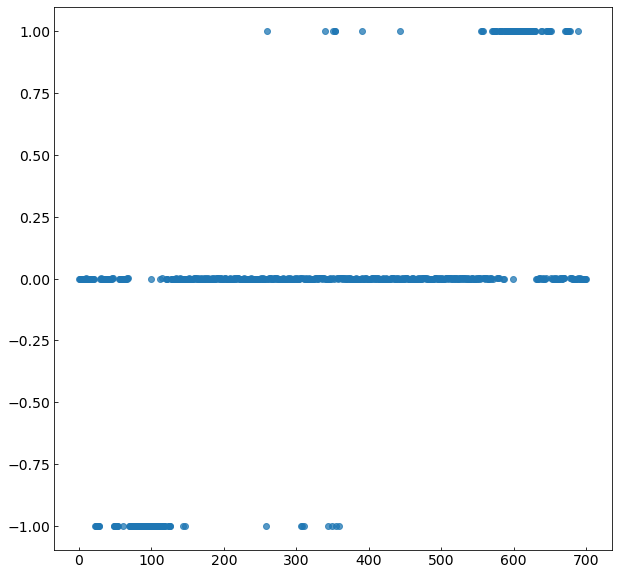

In [8]:
# Plot of indices
check_lens = len(grid_coordinates)
x = np.arange(0,check_lens)

fig, ax = plt.subplots(figsize= (10,10))

ax.plot(np.arange(0, check_lens), Botts, linestyle= '', marker= 'o', alpha= 0.75)

plt.show()

In [10]:
Botts_ones = [(x,y) for y,x in enumerate(Botts) if abs(x) >= 0.5]
with open('Pe_Bott_indices_B_scale_0100.txt', 'w') as file:
    for i in Botts_ones:
        file.write(f'{i}')
        file.write('\n')